In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [5]:
# Read each CSV file
train_df = pd.read_csv(os.path.join('../Data', "train_data.csv"))
undersampled_train_df = pd.read_csv(os.path.join('../Data', "undersampled_train_data.csv"))
oversampled_train_df = pd.read_csv(os.path.join('../Data', "oversampled_train_data.csv"))
extracted_features_train_df = pd.read_csv(os.path.join('../Data', "extracted_features_train_data.csv"))
extracted_features_undersampled_train_df = pd.read_csv(os.path.join('../Data', "extracted_features_undersampled_train_data.csv"))
extracted_features_oversampled_train_df = pd.read_csv(os.path.join('../Data', "extracted_features_oversampled_train_data.csv"))
test_df = pd.read_csv(os.path.join('../Data', "test_data.csv"))

In [6]:
N_SPLITS = 3

# Apply on the original data

In [7]:
X_train = train_df.drop('Class', axis=1).values
y_train = train_df['Class'].values

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_leaf': [50],
    'min_samples_split': [50]
}

# Set up GridSearchCV with Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train the model
grid_rf.fit(X_train, y_train)

# Get the best estimator
random_forest = grid_rf.best_estimator_

print("Best Estimator: ", random_forest)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [8]:
# results of grid search CV
cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,40.727791,1.664925,0.201076,0.012539,5,50,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.96401,0.969393,0.972001,0.968468,0.003327,1,0.98536,0.982283,0.973306,0.980317,0.005114


In [9]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_rf.best_score_)
print(grid_rf.best_estimator_)

Best roc_auc:- 0.9684680399035962
RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [10]:
# Best score with best parameters
best_score = grid_rf.best_score_
best_params = grid_rf.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9684680399035962 with parameters {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [11]:
rf = RandomForestClassifier(**best_params)
original_best_rf_model = rf.fit(X_train, y_train)
y_train_pred = original_best_rf_model.predict(X_train)

In [12]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[227418     33]
 [   133    261]]


In [13]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 0.6624365482233503
Percision: 0.8877551020408163
F1-Score: 0.7587209302325582
Accuracy: 0.9992714345278588
Specificity: 0.9998549138056109
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.66      0.76       394

    accuracy                           1.00    227845
   macro avg       0.94      0.83      0.88    227845
weighted avg       1.00      1.00      1.00    227845



In [14]:
# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

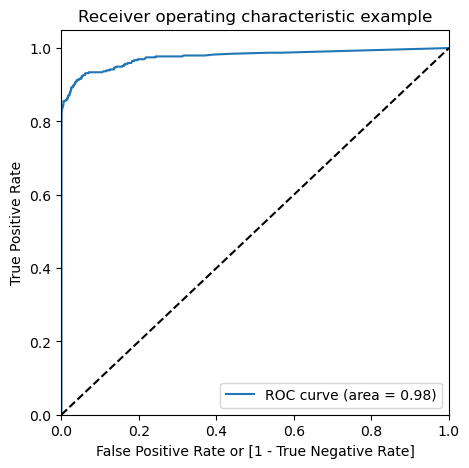

In [15]:
# Predicted probability
y_train_pred_proba = original_best_rf_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [16]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(original_best_rf_model, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9992
test_precision: 0.8701
test_recall: 0.6017
test_f1: 0.7100
test_roc_auc: 0.9651


### Consider the most important features only (V3, V4, V7, V10, V12,V14, V16, V17, V18) on the original data

In [17]:
X_train = extracted_features_train_df.drop('Class', axis=1).values
y_train = extracted_features_train_df['Class'].values

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_leaf': [50],
    'min_samples_split': [50]
}

# Set up GridSearchCV with Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train the model
grid_rf.fit(X_train, y_train)

# Get the best estimator
random_forest = grid_rf.best_estimator_

print("Best Estimator: ", random_forest)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [18]:
# results of grid search CV
cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,27.327445,1.682441,0.162652,0.006527,5,50,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.971842,0.98361,0.98049,0.978647,0.004978,1,0.984532,0.984789,0.980798,0.983373,0.001824


In [19]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_rf.best_score_)
print(grid_rf.best_estimator_)

Best roc_auc:- 0.9786472269513267
RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [20]:
# Best score with best parameters
best_score = grid_rf.best_score_
best_params = grid_rf.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9786472269513267 with parameters {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [21]:
rf = RandomForestClassifier(**best_params)
original_best_rf_model_v2 = rf.fit(X_train, y_train)
y_train_pred = original_best_rf_model_v2.predict(X_train)

In [22]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[221524     18]
 [   108    286]]


In [23]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 0.7258883248730964
Percision: 0.9407894736842105
F1-Score: 0.8194842406876791
Accuracy: 0.9994322687621656
Specificity: 0.9999187512977223
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221542
           1       0.94      0.73      0.82       394

    accuracy                           1.00    221936
   macro avg       0.97      0.86      0.91    221936
weighted avg       1.00      1.00      1.00    221936



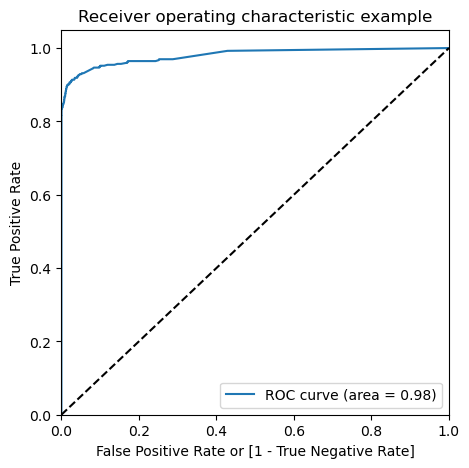

In [24]:
# Predicted probability
y_train_pred_proba = original_best_rf_model_v2.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [25]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(original_best_rf_model_v2, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9994
test_precision: 0.9576
test_recall: 0.6853
test_f1: 0.7989
test_roc_auc: 0.9715


# Apply on the under-sampled data

In [26]:
X_train = undersampled_train_df.drop('Class', axis=1).values
y_train = undersampled_train_df['Class'].values

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_leaf': [50],
    'min_samples_split': [50]
}

# Set up GridSearchCV with Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train the model
grid_rf.fit(X_train, y_train)

# Get the best estimator
random_forest = grid_rf.best_estimator_

print("Best Estimator: ", random_forest)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [27]:
# results of grid search CV
cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.137682,0.004825,0.005619,0.003006,5,50,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.970796,0.972704,0.986889,0.976796,0.007179,1,0.990509,0.986474,0.983316,0.986766,0.002944


In [28]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_rf.best_score_)
print(grid_rf.best_estimator_)

Best roc_auc:- 0.9767962534264032
RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [29]:
# Best score with best parameters
best_score = grid_rf.best_score_
best_params = grid_rf.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9767962534264032 with parameters {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [30]:
rf = RandomForestClassifier(**best_params)
undersampled_best_rf_model = rf.fit(X_train, y_train)
y_train_pred = undersampled_best_rf_model.predict(X_train)

In [31]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[392   2]
 [ 45 349]]


In [32]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 0.8857868020304569
Percision: 0.9943019943019943
F1-Score: 0.9369127516778524
Accuracy: 0.9403553299492385
Specificity: 0.9949238578680203
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       394
           1       0.99      0.89      0.94       394

    accuracy                           0.94       788
   macro avg       0.95      0.94      0.94       788
weighted avg       0.95      0.94      0.94       788



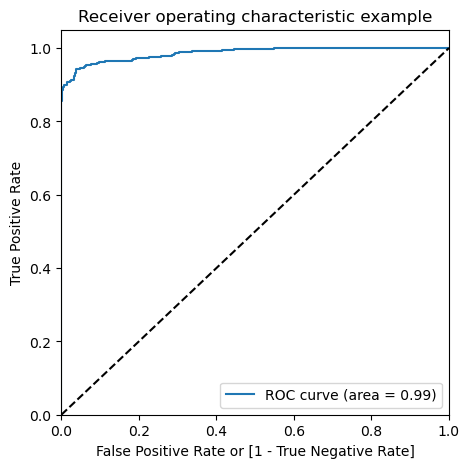

In [33]:
# Predicted probability
y_train_pred_proba = undersampled_best_rf_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [34]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(undersampled_best_rf_model, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9289
test_precision: 0.9971
test_recall: 0.8604
test_f1: 0.9237
test_roc_auc: 0.9776


### Consider the most important features only (V3, V4, V7, V10, V12,V14, V16, V17, V18) on the undersampled data

In [35]:
X_train = extracted_features_undersampled_train_df.drop('Class', axis=1).values
y_train = extracted_features_undersampled_train_df['Class'].values

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_leaf': [50],
    'min_samples_split': [50]
}

# Set up GridSearchCV with Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train the model
grid_rf.fit(X_train, y_train)

# Get the best estimator
random_forest = grid_rf.best_estimator_

print("Best Estimator: ", random_forest)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [36]:
# results of grid search CV
cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.123174,0.007177,0.010279,0.005396,5,50,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.974018,0.975728,0.982944,0.977563,0.003868,1,0.988192,0.984538,0.983142,0.985291,0.002129


In [37]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_rf.best_score_)
print(grid_rf.best_estimator_)

Best roc_auc:- 0.9775629325217827
RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [38]:
# Best score with best parameters
best_score = grid_rf.best_score_
best_params = grid_rf.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9775629325217827 with parameters {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [39]:
rf = RandomForestClassifier(**best_params)
undersampled_best_rf_model_v2 = rf.fit(X_train, y_train)
y_train_pred = undersampled_best_rf_model_v2.predict(X_train)

In [40]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[382   2]
 [ 42 352]]


In [41]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 0.8934010152284264
Percision: 0.9943502824858758
F1-Score: 0.9411764705882353
Accuracy: 0.9434447300771208
Specificity: 0.9947916666666666
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       384
           1       0.99      0.89      0.94       394

    accuracy                           0.94       778
   macro avg       0.95      0.94      0.94       778
weighted avg       0.95      0.94      0.94       778



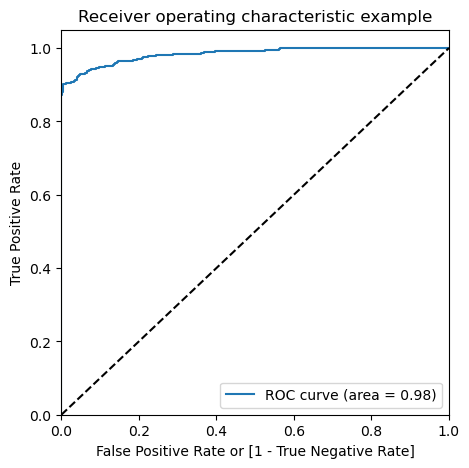

In [42]:
# Predicted probability
y_train_pred_proba = undersampled_best_rf_model_v2.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [43]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(undersampled_best_rf_model_v2, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9370
test_precision: 0.9917
test_recall: 0.8832
test_f1: 0.9342
test_roc_auc: 0.9788


# Apply on the over-sampled data

In [44]:
X_train = oversampled_train_df.drop('Class', axis=1).values
y_train = oversampled_train_df['Class'].values

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_leaf': [50],
    'min_samples_split': [50]
}

# Set up GridSearchCV with Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train the model
grid_rf.fit(X_train, y_train)

# Get the best estimator
random_forest = grid_rf.best_estimator_

print("Best Estimator: ", random_forest)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [45]:
# results of grid search CV
cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,87.79634,3.441133,0.547395,0.03981,5,50,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.992513,0.992429,0.992573,0.992505,0.000059,1,0.992112,0.992931,0.992845,0.992629,0.000368


In [46]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_rf.best_score_)
print(grid_rf.best_estimator_)

Best roc_auc:- 0.9925051107729
RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [47]:
# Best score with best parameters
best_score = grid_rf.best_score_
best_params = grid_rf.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9925051107729 with parameters {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [48]:
rf = RandomForestClassifier(**best_params)
oversampled_best_rf_model = rf.fit(X_train, y_train)
y_train_pred = oversampled_best_rf_model.predict(X_train)

In [49]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[226367   1084]
 [ 24500 202951]]


In [50]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 0.8922844920444404
Percision: 0.994687186022006
F1-Score: 0.9407072303620512
Accuracy: 0.9437593151931625
Specificity: 0.9952341383418847
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    227451
           1       0.99      0.89      0.94    227451

    accuracy                           0.94    454902
   macro avg       0.95      0.94      0.94    454902
weighted avg       0.95      0.94      0.94    454902



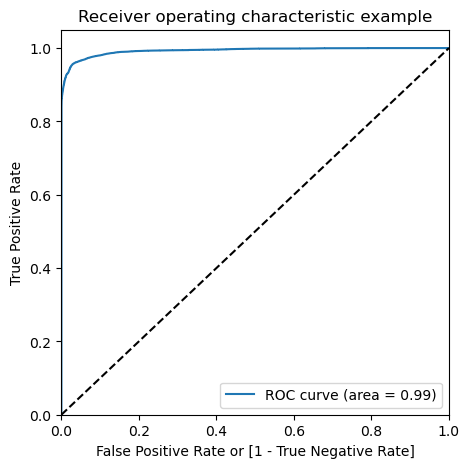

In [51]:
# Predicted probability
y_train_pred_proba = oversampled_best_rf_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [52]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(oversampled_best_rf_model, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9455
test_precision: 0.9933
test_recall: 0.8970
test_f1: 0.9427
test_roc_auc: 0.9923


### Consider the most important features only (V3, V4, V7, V10, V12,V14, V16, V17, V18) on the oversampled data

In [53]:
X_train = extracted_features_oversampled_train_df.drop('Class', axis=1).values
y_train = extracted_features_oversampled_train_df['Class'].values

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_leaf': [50],
    'min_samples_split': [50]
}

# Set up GridSearchCV with Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train the model
grid_rf.fit(X_train, y_train)

# Get the best estimator
random_forest = grid_rf.best_estimator_

print("Best Estimator: ", random_forest)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [54]:
# results of grid search CV
cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,57.059711,1.816411,0.468044,0.009003,5,50,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.991035,0.990538,0.991061,0.990878,0.000241,1,0.99086,0.991138,0.99103,0.991009,0.000114


In [55]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_rf.best_score_)
print(grid_rf.best_estimator_)

Best roc_auc:- 0.9908779259201997
RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [56]:
# Best score with best parameters
best_score = grid_rf.best_score_
best_params = grid_rf.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9908779259201997 with parameters {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [57]:
rf = RandomForestClassifier(**best_params)
oversampled_best_rf_model_v2 = rf.fit(X_train, y_train)
y_train_pred = oversampled_best_rf_model_v2.predict(X_train)

In [58]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[217846   3696]
 [ 18502 208949]]


In [59]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 0.9186550070124994
Percision: 0.9826189188553692
F1-Score: 0.9495610048716644
Accuracy: 0.9505604764439535
Specificity: 0.983316933132318
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    221542
           1       0.98      0.92      0.95    227451

    accuracy                           0.95    448993
   macro avg       0.95      0.95      0.95    448993
weighted avg       0.95      0.95      0.95    448993



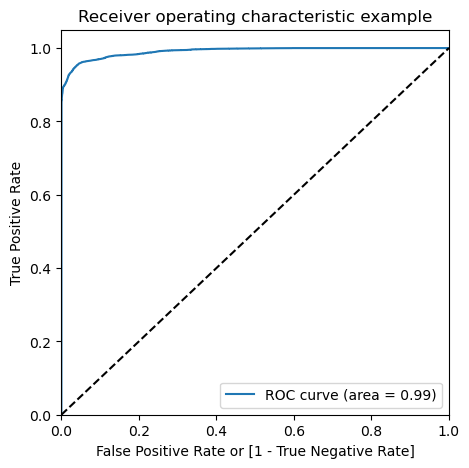

In [60]:
# Predicted probability
y_train_pred_proba = oversampled_best_rf_model_v2.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [61]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(oversampled_best_rf_model_v2, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9504
test_precision: 0.9835
test_recall: 0.9175
test_f1: 0.9494
test_roc_auc: 0.9908


In [69]:
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Get importances
importances = rf.feature_importances_

# Put into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

     Feature  Importance
5  Feature_5    0.429648
3  Feature_3    0.231194
4  Feature_4    0.135461
1  Feature_1    0.091883
7  Feature_7    0.070069
0  Feature_0    0.017383
6  Feature_6    0.008848
8  Feature_8    0.008263
2  Feature_2    0.007252


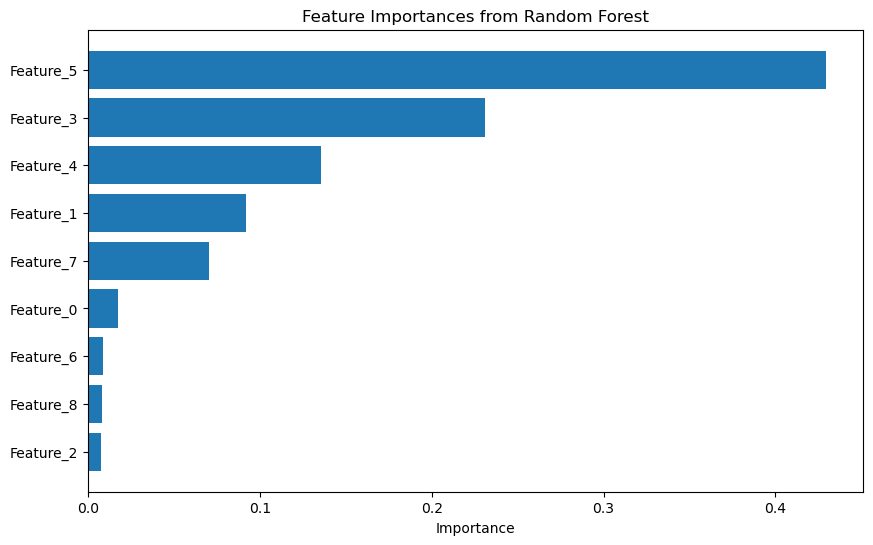

In [70]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()